### Steps to Download and Set Up SAM-3 (Segment Anything Model v3)

- **Check prerequisites**
  - Python ≥ 3.8  
  - PyTorch ≥ 2.0 (CUDA-enabled if using GPU)  
  - Git installed  

- **Create and activate a clean environment (if not done already)**
  - Use `conda` or `venv` to avoid dependency conflicts  
  - Install PyTorch matching your CUDA version    

- **Use Ultralytics to install SAM 3**
  - www.ultralytics.com

- **Download SAM-3 pretrained weights**
  - Find the SAM-3 checkpoint links in the repository or release notes  
  - Download the `.pth` model weights  
  - Place them in the recommended `checkpoints/` directory  

- **Verify model files**
  - Ensure checkpoint filenames match what the code expects  
  - Confirm the files downloaded correctly  

- **Test installation**
  - Run the provided demo or inference script  
  - Verify that segmentation masks are generated on a sample image  

- **Enable GPU acceleration**
  - Move the model to GPU using `model.to("cuda")`  
  - Check GPU availability with `torch.cuda.is_available()`  

- **Integrate with your own data**
  - Replace demo images with your dataset  
  - Use automatic or prompt-based segmentation as needed  

---

**Summary:**  
*Clone repo → install dependencies → download SAM-3 weights → run demo → apply to your data*


Ultralytics 8.4.5 🚀 Python-3.12.9 torch-2.7.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
WARNING ⚠️ imgsz=[640] must be multiple of max stride 14, updating to [644]

0: 644x644 39 vegetations, 40.6ms
Speed: 1.9ms preprocess, 40.6ms inference, 1.5ms postprocess per image at shape (1, 3, 644, 644)
Results saved to /mnt/g/Guwahati 3D Segment/sam_codes/runs/segment/predict4


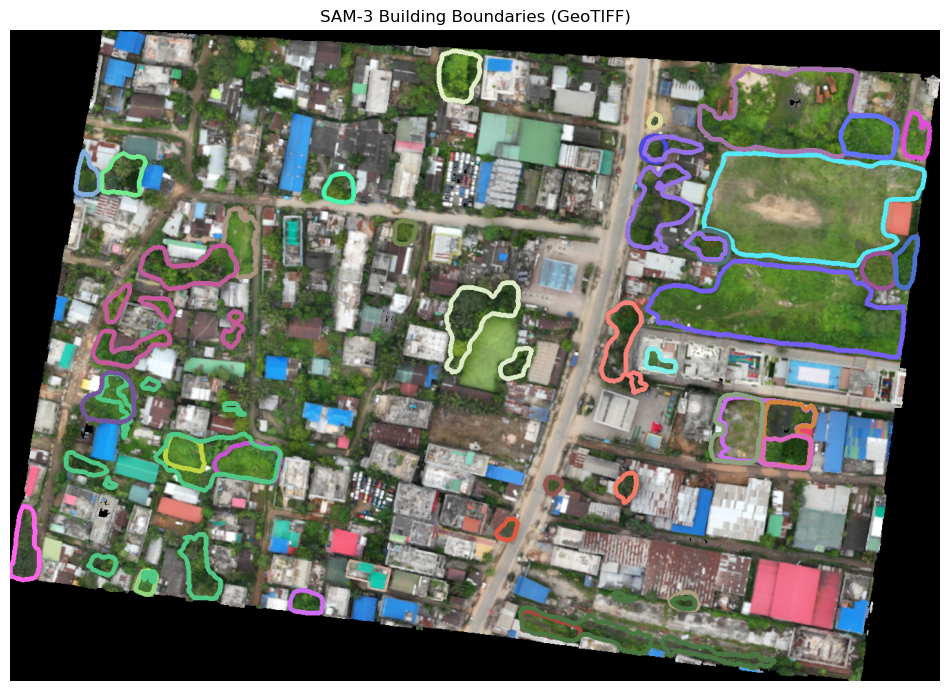

Total detected instances: 39


In [ ]:
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio
from rasterio.enums import Resampling

from ultralytics.models.sam import SAM3SemanticPredictor

# ------------------------------------------------------------------
# File paths
# ------------------------------------------------------------------
MODEL_PATH =    "/mnt/e/sam3.pt"
GEOTIFF_PATH =  "/mnt/c/Users/anild/Documents/rgb.tif"
OUT_TIFF =      "/mnt/c/Users/anild/Documents/sam3_building_boundaries.tif"

# ------------------------------------------------------------------
# Initialize SAM-3 predictor
# ------------------------------------------------------------------
overrides = dict(
    model=str(MODEL_PATH),
    task="segment",
    mode="predict",
    conf=0.25,
    half=True,
    device="cuda"
)

predictor = SAM3SemanticPredictor(overrides=overrides)

# ------------------------------------------------------------------
# Read GeoTIFF and preserve georeferencing
# ------------------------------------------------------------------
with rasterio.open(GEOTIFF_PATH) as src:
    profile = src.profile
    transform = src.transform
    crs = src.crs

    # Read RGB bands
    img = src.read([1, 2, 3])

# Convert from (bands, rows, cols) to (rows, cols, channels)
image_rgb = np.moveaxis(img, 0, -1)

# Ensure image is uint8-compatible for SAM
if image_rgb.dtype != np.uint8:
    image_rgb = cv2.normalize(
        image_rgb, None, 0, 255, cv2.NORM_MINMAX
    ).astype(np.uint8)

# ------------------------------------------------------------------
# Pass image array directly to SAM-3
# ------------------------------------------------------------------
predictor.set_image(image_rgb)

# ------------------------------------------------------------------
# Run text-prompt based segmentation
# ------------------------------------------------------------------
# text_prompts = ["building"]
text_prompts = ["vegetation"]
results = predictor(text=text_prompts)
result = results[0]

if result.masks is None:
    raise RuntimeError("No masks detected")

# ------------------------------------------------------------------
# Output image buffer
# ------------------------------------------------------------------
output = image_rgb.copy()

random.seed(42)

def random_color():
    return (
        random.randint(60, 255),
        random.randint(60, 255),
        random.randint(60, 255),
    )

# ------------------------------------------------------------------
# Extract and draw object boundaries only
# ------------------------------------------------------------------
masks = result.masks.data.cpu().numpy()  # (N, H, W)

for i in range(len(masks)):
    mask = (masks[i] > 0.5).astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    color = random_color()

    for cnt in contours:
        if cv2.contourArea(cnt) < 100:
            continue

        cv2.drawContours(
            output,
            [cnt],
            -1,
            color,
            thickness=6
        )

# ------------------------------------------------------------------
# Visualization
# ------------------------------------------------------------------
plt.figure(figsize=(12, 12))
plt.imshow(output)
plt.axis("off")
plt.title("SAM-3 Building Boundaries (GeoTIFF)")
plt.show()

print(f"Total detected instances: {len(masks)}")

# ------------------------------------------------------------------
# Write georeferenced output GeoTIFF
# ------------------------------------------------------------------
out_profile = profile.copy()
out_profile.update(
    dtype=rasterio.uint8,
    count=3,
    compress="lzw"
)

with rasterio.open(OUT_TIFF, "w", **out_profile) as dst:
    dst.write(np.moveaxis(output, -1, 0))
